In [53]:
# Imports
from rocketpy import Environment, HybridMotor, Rocket, Flight, MassBasedTank, CylindricalTank, Fluid
import datetime
import pandas as pd
import numpy as np

In [54]:
# TODO : Automate data with csv on drive
# TODO : Get missing data values
help(HybridMotor)

Help on class HybridMotor in module rocketpy.motors.hybrid_motor:

class HybridMotor(rocketpy.motors.motor.Motor)
 |  HybridMotor(thrust_source, dry_mass, dry_inertia, nozzle_radius, grain_number, grain_density, grain_outer_radius, grain_initial_inner_radius, grain_initial_height, grain_separation, grains_center_of_mass_position, center_of_dry_mass_position, nozzle_position=0, burn_time=None, throat_radius=0.01, reshape_thrust_curve=False, interpolation_method='linear', coordinate_system_orientation='nozzle_to_combustion_chamber')
 |
 |  Class to specify characteristics and useful operations for Hybrid
 |  motors. This class inherits from the Motor class.
 |
 |  See Also
 |  --------
 |  Motor
 |
 |  Attributes
 |  ----------
 |  HybridMotor.coordinate_system_orientation : str
 |      Orientation of the motor's coordinate system. The coordinate system
 |      is defined by the motor's axis of symmetry. The origin of the
 |      coordinate system may be placed anywhere along such axis, 

In [55]:
# Chargement des fichiers csv en arrays
# Coefficient drag de la fusée lorsque le moteur est éteint ou non
powerDragOn  = pd.read_csv('Data/powerDrag.CSV', usecols=["CD Power-On"]).to_numpy()
powerDragOff = pd.read_csv('Data/powerDrag.CSV', usecols=["CD Power-Off"]).to_numpy()

# Stability caliber margins selon RasAero II
cal = pd.read_csv('Data/Stability.CSV', usecols=['Stability Margin (cal)']).to_numpy()

In [56]:
# Chargement données pour le tank
# TODO : Add spherical caps without errors (height and radius too small?)
cylinder = CylindricalTank(
    radius = 0.076327,
    height = 1.761744
)
# TODO : Vérifier densité
# https://docs.rocketpy.org/en/latest/user/motors/tanks.html#tanks-usage
liquid_N2O = Fluid(name="Liquid Nitrous Oxide", density=855)
vapour_N2O = Fluid(name="Vapour Nitrous Oxide", density=101)

In [57]:
# Chargement données pour le moteur hybride
SOURCE    = "HYB30kpar.eng"
NAME      = "Kraken2.0"
BURN_TIME = 12.25
MOTOR_POSITION = (-2.879852 - 0.00635) # Position selon le centre de masse de la fusée (négatif car tail_to_nose)
COORDS_ORIENTATION ="nozzle_to_combustion_chamber"

# Masse solide
DRY_MASS    = 16940/1000                    # Masse de la structure excluant le propellant [Bilan masses]
DRY_INERTIA = [0.98, 0.98 , 0.06, 0, 0, 0]  # Inertie de la masse solide (liste en kg*m^2) Solidworks (I_11, I_22, I_33, I_12, I_13, I_23)
CM_DRY      =  0.297434 - 0.40513           # Centre de masse de la masse solide (m)

NOZZLE_RADIUS =  0.0760476
NOZZLE_POS    = -2.879852 - 0.00635 # Position du nozzle selon le nose cone
THROAT_RADIUS =  0.042291           # ? Rayon du throat du nozzle. Pas nécessaire dans certains simulations

# Grain data
GRAIN_N         = 1           # Nombre de grains
GRAIN_DENSITY   = 0.503381099 # Densité du grain (kg/m^3)
GRAIN_ORAD      = 0.063881    # rayon extérieur du grain (m)
GRAIN_INIT_IRAD = 0.030988    # rayon initial intérieur (m)
GRAIN_INIT_H    = 0.22225     # Hauteur initiale (m)
GRAIN_SEP       = 0           # Distance entre 2 grains (0 car 1 seul grain)
GRAIN_CM        = 0           # Centre de masse (m)

In [58]:
# Chargement données pour l'environnement du vol
DATE      = datetime.datetime(2023, 12, 12) # Date du launch (Y, M, D)
ELEVATION = 1400    # Élévation du site de launch
GEO_DATUM = 'NAD83' # Référence spatiale pour le Canada (correction de données)
TIMEZONE  = 'GMT-5'
MAX_H     = 30000   # Hauteur maximal attendu en m. Utilisé pour  ne pas avoir un surplus de données
LAT       = 0       # Latitude du spaceport
LON       = 0       # Longitude du spaceport

In [59]:
# Chargement données de la fusée
# Construction fusée
ROCKET_RAD     = 0.18                                   # le rayon maximal de la fusée (excluant les ailettes) en mètres
ROCKET_MASS    = 47.80                                  # Masse de la fusée sans le moteur (kg) [Solidworks]
ROCKET_INERTIA = [94.91, 94.90, 0.27, 0, -0.09, 0]      # liste des inerties. [I_11, I_22, I_33, I_12, I_13, I_23]
ROCKET_CM      = -0.04                                  # Centre de masse de la fusée sans le moteur
ROCKET_COORDS  = "tail_to_nose"                         # Référence pour tous les données de type mesures (longeur, cm, etc.)

# Nose cone
NC_L     = 0.79          # Longueur du nose cone
NC_KIND  = "von karman"  # Forme du nose cone
NC_POS   = 2.525776      # Position du nose cone (tail to nose)
NC_BLUFF = 0             # Ratio entre le rayon du tip de l'ogive et le rayon à la base de l'ogive. Optionnel

# Ailettes
FIN_N     = 3         # nombre d'ailettes
FIN_SPAN  = 0.17      # Hauteur des ailettes en mètres
FIN_RC    = 0.437134  # Root chord des ailettes en mètres
FIN_TC    = 0.127     # Tip chord des ailettes en mètres
FIN_POS   = -2.455164 # Position du top des ailettes à partir du cm en mètres
FIN_SWEEP = 0.249174  # Sweep length en mètres

# Boattail
TAIL_TOP    = 0.174244  # Rayon du top du tail en mètres
TAIL_BOTTOM = 0.092456  # Rayon du bottom du tail en mètres
TAIL_L      = 0.058674  # Longueur du tail en mètres
TAIL_POS    = -2.879852 # Position du tail selon le cm de la fusée en mètres (négatif car tail_to_nose)

# Parachutes
MAIN_NAME  = "Main Parachute" # Nom du parachute principal
MAIN_CD    = 0 # F = ((1/2)*rho*V^2)*cd_s === Coefficient drag * aire référence. Utilisé pour calculer la force du drag
MAIN_EJECT = 0 # Hauteur d'éjection du parachute en mètres
MAIN_LAG   = 0 # Temps entre trigger et éjection en secondes (optionel)

DRAG_NAME  = "Drag Parachute"
DRAG_CD    = 0
DRAG_EJECT = 0
DRAG_LAG   = 0

# Rails
BUTTON_TOP    = 0 # Position du bouton le plus éloigné du nozzle (selon nose cone) (m) pas necessaire
BUTTON_BOTTOM = 0 # Position du bouton le plus proche du nozzle (selon nose cone) (m)pas necessaire
BUTTON_ANG    = 0 # Position angulaire des boutons en degrés (selon axes symmétriques de la fusée relative aux axes principales)

In [60]:
# Chargement données pour la simulation du vol
RAIL_L    = 0 # Longueur de la surface entre la fusée et le rail
RAIL_INC  = 0 # Inclinaison du rail relative au sol en degrés
RAIL_HEAD = 0 # Angle relative au nord en degrés

In [61]:
# # Création du tank
Tank = MassBasedTank(
    name = "Tank",
    flux_time = BURN_TIME, 
    geometry = cylinder,
    liquid = liquid_N2O,
    gas = vapour_N2O,
    gas_mass = # Manque masse gas selon temps (kg/s)
    liquid_mass = # manque masse liquide selon le temps
)

SyntaxError: invalid syntax (4251420425.py, line 9)

In [ ]:
# Création du moteur
# TODO : make tank then add to motor
Kraken = HybridMotor(
    thrust_source = SOURCE,
    dry_mass      = DRY_MASS,
    dry_inertia   = DRY_INERTIA,
    center_of_dry_mass_position = CM_DRY,

    nozzle_radius   = NOZZLE_RADIUS,
    nozzle_position = NOZZLE_POS,
    throat_radius   = THROAT_RADIUS,

    grain_number         = GRAIN_N,
    grain_density        = GRAIN_DENSITY,
    grain_outer_radius   = GRAIN_ORAD,
    grain_initial_height = GRAIN_INIT_H,
    grain_separation     = GRAIN_SEP,
    grain_initial_inner_radius     = GRAIN_INIT_IRAD,
    grains_center_of_mass_position = GRAIN_CM,

    coordinate_system_orientation  = COORDS_ORIENTATION,
    burn_time = BURN_TIME
)
Kraken.all_info()

In [ ]:
# Création de la fusée
kronos = Rocket(
    radius  = ROCKET_RAD,
    mass    = ROCKET_MASS,
    inertia = ROCKET_INERTIA,
    center_of_mass_without_motor  = ROCKET_CM,
    coordinate_system_orientation = ROCKET_COORDS,
    power_off_drag = powerDragOn,
    power_on_drag  = powerDragOff
)

# Ajout nose cone
nose = kronos.add_nose(
    length    = NC_L,
    kind      = NC_KIND,
    position  = NC_POS
    # bluffness = NC_BLUFF
)

# Ajout parachutes
main_parachute = kronos.add_parachute(
    name    = MAIN_NAME,
    cd_s    = MAIN_CD,
    trigger = MAIN_EJECT,
    lag     = MAIN_LAG
)

drag_parachute = kronos.add_parachute(
    name    = DRAG_NAME,
    cd_s    = DRAG_CD,
    trigger = DRAG_EJECT,
    lag     = DRAG_LAG
)

# Ajout ailettes
fins = kronos.add_trapezoidal_fins(
    n           = FIN_N,
    root_chord  = FIN_RC,
    tip_chord   = FIN_TC,
    span        = FIN_SPAN,
    position    = FIN_POS,
    sweep_angle = FIN_SWEEP
)

# Ajout moteur
kronos.add_motor(Kraken, MOTOR_POSITION)

# Ajout boattail
boattail = kronos.add_tail(
    top_radius    = TAIL_TOP,
    bottom_radius = TAIL_BOTTOM,
    length        = TAIL_L,
    position      = TAIL_POS
)

# Ajout rails pas necessaire
# buttons = kronos.set_rail_buttons(
#     angular_position      = BUTTON_ANG
# )


Gravity Details

Acceleration of Gravity at Lauch Site: 9.78032515258835 m/s²


Launch Site Details

Launch Date: 2023-12-12 00:00:00 UTC
Launch Site Latitude: 0.00000°
Launch Site Longitude: 0.00000°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 166021.44 W|E    0.00 N
Launch Site UTM zone: 31N
Launch Site Surface Elevation: 0.1 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 80.295 km
Forecast Time Period: From  2023-11-26 12:00:00  to  2023-12-12 12:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 5.91 m/s
Surface Wind Direction: 154.62°
Surface Wind Heading: 334.62°
Surface Pressure: 1000.00 hPa
Surface Temperature: 298.79 K
Surface Air Density: 1.166 kg/m³
Surface Speed of Sound: 346.52 m/s



Gravity Model Plots


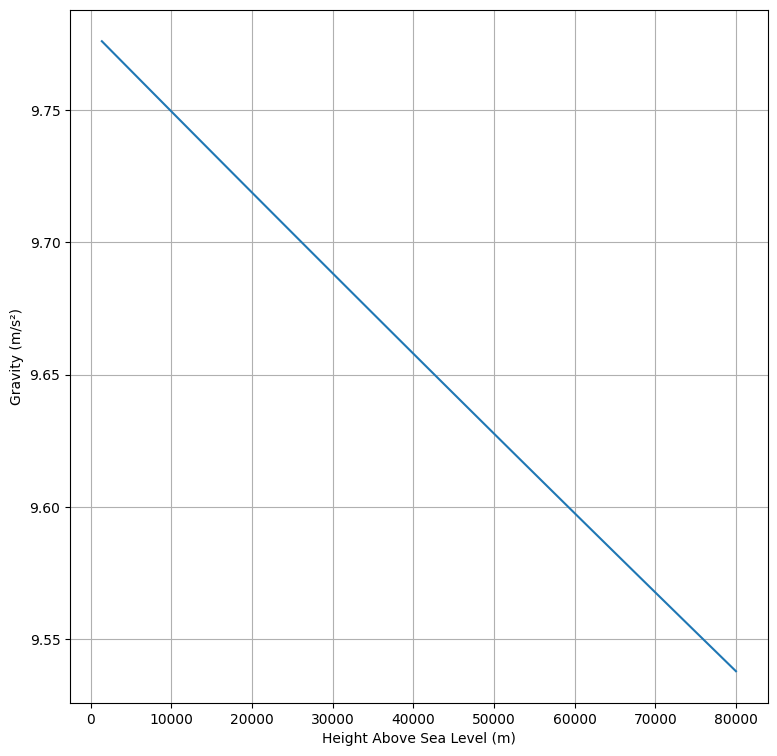



Atmospheric Model Plots


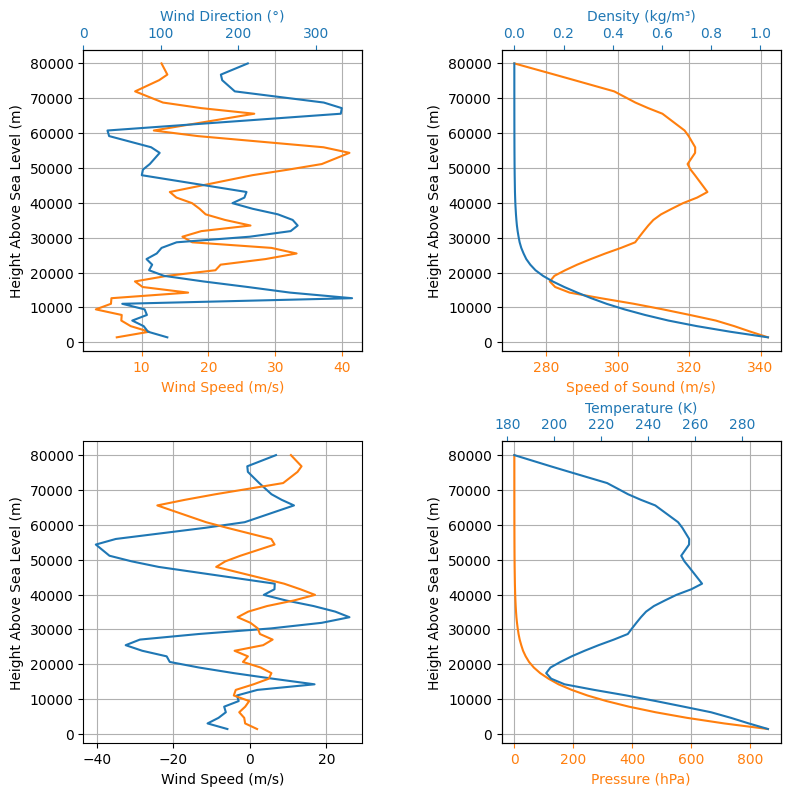

In [64]:
# Creation de l'environment use gfs
env = Environment(
    date      = DATE,
    latitude  = LAT,
    longitude = LON,
    elevation = ELEVATION
)
env.set_date(DATE)
env.set_atmospheric_model(type="Forecast", file="GFS")
env.all_info()

In [63]:
# Simulation du vol
test_flight = Flight(
    rocket      = kronos,
    environment = env,
    rail_length = RAIL_L,
    inclination = RAIL_INC,
    heading     = RAIL_HEAD  
)

test_flight.info()

ValueError: Rail length must be a positive value.